In [1]:
import numpy as np
import os

# Load the data
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    # Load items into a dictionary
    cifar = dict(npz_file.items())

overfeat = cifar['overfeat']
labels = cifar['labels']

# split the Overfeat data into train/test sets w/ same proportion of classes in each subset

import pandas as pd
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(
    overfeat, labels, train_size=4000, test_size=1000, 
    stratify=labels , # same class distribution
    random_state=0)

print('Train:', X_tr.shape, y_tr.shape)
print('Test:', X_te.shape, y_te.shape)

Train: (4000, 4096) (4000,)
Test: (1000, 4096) (1000,)


### Create a logistic regression classifier and tune the regularization strength.

In [3]:
# first, tune only the regularization strength of the estimator

from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create decision tree classifier
pipe = Pipeline([
    ('pca', None), # no PCA preprocessing
    ('log_reg', SGDClassifier(loss='log', # logistic regression estimator with stochastic gradient descent (SGD)
                              max_iter=1000, tol=1e-3, random_state=0))                              
])

# grid search with cross validation
from sklearn.model_selection import GridSearchCV

# Create cross-validation object
grid_cv = GridSearchCV(pipe, {
    'log_reg__alpha': list(np.linspace(0.00001,1,20)) # tune the regularization strength
    },
    cv=5, n_jobs = -1,verbose = 2) # stratified 5-fold strategy

# Fit estimator on train set
grid_cv.fit(X_tr, y_tr)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] log_reg__alpha=1e-05 ............................................
[CV] log_reg__alpha=1e-05 ............................................
[CV] log_reg__alpha=1e-05 ............................................
[CV] log_reg__alpha=1e-05 ............................................
[CV] ............................. log_reg__alpha=1e-05, total=   3.8s
[CV] log_reg__alpha=1e-05 ............................................
[CV] ............................. log_reg__alpha=1e-05, total=   4.2s
[CV] log_reg__alpha=0.05264105263157895 ..............................
[CV] ............................. log_reg__alpha=1e-05, total=   4.0s
[CV] log_reg__alpha=0.05264105263157895 ..............................
[CV] ............................. log_reg__alpha=1e-05, total=   4.7s
[CV] log_reg__alpha=0.05264105263157895 ..............................
[CV] ............................. log_reg__alpha=1e-05, total=   2.8s
[CV] log_reg__a

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.6s


[CV] ................ log_reg__alpha=0.3157963157894737, total=   2.5s
[CV] log_reg__alpha=0.3684273684210526 ...............................
[CV] ................ log_reg__alpha=0.3684273684210526, total=   2.7s
[CV] log_reg__alpha=0.3684273684210526 ...............................
[CV] ................ log_reg__alpha=0.3684273684210526, total=   2.5s
[CV] log_reg__alpha=0.3684273684210526 ...............................
[CV] ................ log_reg__alpha=0.3157963157894737, total=   3.1s
[CV] log_reg__alpha=0.4210584210526316 ...............................
[CV] ................ log_reg__alpha=0.3684273684210526, total=   2.4s
[CV] log_reg__alpha=0.4210584210526316 ...............................
[CV] ................ log_reg__alpha=0.3684273684210526, total=   2.4s
[CV] log_reg__alpha=0.4210584210526316 ...............................
[CV] ................ log_reg__alpha=0.3684273684210526, total=   2.5s
[CV] log_reg__alpha=0.4210584210526316 ...............................
[CV] .

[CV] ................. log_reg__alpha=0.947368947368421, total=   2.2s
[CV] log_reg__alpha=1.0 ..............................................
[CV] ................. log_reg__alpha=0.947368947368421, total=   2.0s
[CV] log_reg__alpha=1.0 ..............................................
[CV] ................. log_reg__alpha=0.947368947368421, total=   1.8s
[CV] log_reg__alpha=1.0 ..............................................
[CV] ................. log_reg__alpha=0.947368947368421, total=   1.8s
[CV] log_reg__alpha=1.0 ..............................................
[CV] ............................... log_reg__alpha=1.0, total=   1.9s
[CV] log_reg__alpha=1.0 ..............................................
[CV] ............................... log_reg__alpha=1.0, total=   1.9s
[CV] ............................... log_reg__alpha=1.0, total=   1.5s
[CV] ............................... log_reg__alpha=1.0, total=   1.8s
[CV] ............................... log_reg__alpha=1.0, total=   1.3s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', None), ('log_reg', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=0.001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'log_reg__alpha': [1e-05, 0.05264105263157895, 0.10527210526315789, 0.15790315789473686, 0.2105342105263158, 0.26316526315789474, 0.3157963157894737, 0.3684273684210526, 0.4210584210526316, 0.47368947368421055, 0.5263205263157894, 0.5789515789473684, 0.6315826315789473, 0.6842136842105263, 0.7368447368421052, 0.7894757894736841, 0.8421068421052631, 0.8947378947368421, 0.947368947368421, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose

In [4]:
import pandas as pd

# Collect results in a DataFrame
df = pd.DataFrame.from_items([
    ('alpha', grid_cv.cv_results_['param_log_reg__alpha']),
    ('mean_te', grid_cv.cv_results_['mean_test_score']),
    ('std_te', grid_cv.cv_results_['std_test_score'])
])
df.sort_values(by='mean_te', ascending=False).head(10)

,alpha,mean_te,std_te
3,0.157903,0.83450,0.013978
9,0.473689,0.83450,0.019439
1,0.0526411,0.83400,0.017382
4,0.210534,0.83250,0.013624
10,0.526321,0.83175,0.018003
2,0.105272,0.83125,0.019764
11,0.578952,0.82900,0.016741
8,0.421058,0.82850,0.018207
5,0.263165,0.82825,0.021193
12,0.631583,0.82750,0.015350


In [5]:
# grid search with fewer values for alpha and PCA

# Create decision tree classifier
pipe = Pipeline([
    ('pca', PCA()), # PCA preprocessing
    ('log_reg', SGDClassifier(loss='log', # logistic regression estimator with stochastic gradient descent (SGD)
                              max_iter=1000, tol=1e-3, random_state=0))                              
])

# Create cross-validation object
grid_cv = GridSearchCV(pipe, [{
    'pca__n_components': [61,172, 400], # with PCA
    'log_reg__alpha': list(np.linspace(0.001,0.5,8)) # tune the regularization strength
    }, { 'pca': [None], # without PCA
    'log_reg__alpha': list(np.linspace(0.001,0.5,8)) # tune the regularization strength
    }],
    cv=5, n_jobs = -1,verbose = 1) # stratified 5-fold strategy

# Fit estimator on train set
grid_cv.fit(X_tr, y_tr)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  2.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('log_reg', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1...y='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=0.001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'pca__n_components': [61, 172, 400], 'log_reg__alpha': [0.001, 0.07228571428571429, 0.14357142857142857, 0.21485714285714286, 0.28614285714285714, 0.35742857142857143, 0.4287142857142857, 0.5]}, {'pca': [None], 'log_reg__alpha': [0.001, 0.07228571428571429, 0.14357142857142857, 0.21485714285714286, 0.28614285714285714, 0.35742857142857143, 0.4287142857142857, 0.5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [6]:
# Collect results in a DataFrame
df = pd.DataFrame.from_items([
    ('alpha', grid_cv.cv_results_['param_log_reg__alpha']),
    ('pca', grid_cv.cv_results_['param_pca']),
    ('pca comp', grid_cv.cv_results_['param_pca__n_components']),
    ('mean_te', grid_cv.cv_results_['mean_test_score']),
    ('std_te', grid_cv.cv_results_['std_test_score'])
])
df.sort_values(by='mean_te', ascending=False).head(10)

,alpha,pca,pca comp,mean_te,std_te
25,0.0722857,None,NaN,0.83525,0.017128
27,0.214857,None,NaN,0.83300,0.013360
31,0.5,None,NaN,0.83225,0.018497
26,0.143571,None,NaN,0.83200,0.014243
14,0.286143,NaN,400,0.83075,0.014866
30,0.428714,None,NaN,0.83050,0.018618
8,0.143571,NaN,400,0.83025,0.012334
1,0.001,NaN,172,0.83000,0.013761
11,0.214857,NaN,400,0.82950,0.012590
20,0.428714,NaN,400,0.82875,0.013987


In [7]:
best = df.sort_values(by='mean_te', ascending=False)[0:1]
print('Top accuracy across folds:', best.iloc[0,3],
      '(std:)', best.iloc[0,4], ' with', best.iloc[0,2], 'components', ' and alpha:', best.iloc[0,0])

Top accuracy across folds: 0.83525 (std:) 0.01712819313296065  with nan components  and alpha: 0.07228571428571429


In [8]:
# evaluate its accuracy on the test set
accuracy = grid_cv.best_estimator_.score(X_te, y_te)
print ('Logistic regression accuracy on the test set: {:.3f}'.format(accuracy))

Logistic regression accuracy on the test set: 0.840


### Pick ten images from the test set and compute the probabilities for each class.

In [9]:
# Pick ten images from the test set 
# and compute the probability of each class using the predict_proba() function of your estimator. 
import random
random_img = random.sample(range(0, len(X_te)), 10)
probability = grid_cv.best_estimator_.predict_proba(X_te[random_img])

df_img = pd.DataFrame(probability, columns=['truck','car','airplane','ship']).round(2)

In [10]:
df_img

,truck,car,airplane,ship
0,0.93,0.05,0.00,0.02
1,0.00,0.00,1.00,0.00
2,0.94,0.06,0.00,0.00
3,0.23,0.02,0.02,0.72
4,0.04,0.04,0.01,0.90
5,0.01,0.00,0.14,0.85
6,0.81,0.00,0.13,0.06
7,0.00,0.04,0.00,0.96
8,0.00,0.01,0.99,0.00
9,0.00,0.00,0.46,0.54


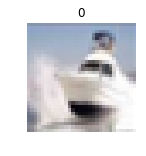

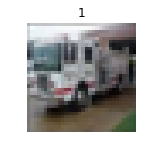

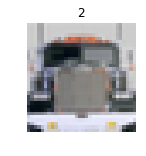

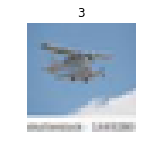

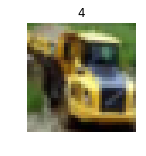

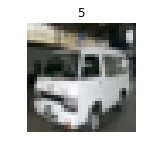

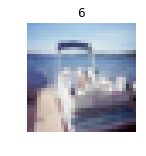

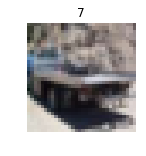

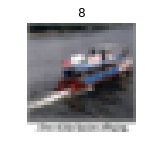

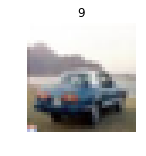

In [17]:
# Plotting the results
%matplotlib inline
import matplotlib.pyplot as plt

results = cifar['pixels'][random_img]
for i in range(len(results)):
    flat_img = results [i,:]
    img = flat_img.reshape(32, 32, 3)
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(img)
    plt.title(i)
    plt.show()